In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# my libraries
import defs

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.mps.manual_seed(10)

print(os.listdir("../Datasets/input_classification"))


['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata']


In [2]:
data_dir = '../Datasets/input_segmentation'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
    

In [3]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs


In [4]:
norm_mean,norm_std = compute_img_mean_std(all_image_path)


100%|██████████| 10015/10015 [02:00<00:00, 82.78it/s]


(224, 224, 3, 10015)
normMean = [0.7630331, 0.5456457, 0.5700467]
normStd = [0.1409281, 0.15261227, 0.16997086]


In [5]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2


In [6]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1


In [7]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2,duplicated


In [8]:
df_original['duplicates'].value_counts()


duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [9]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape


(5514, 12)

In [10]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape


c:\Users\Krystian\miniconda3\envs\pytorch_1\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Krystian\miniconda3\envs\pytorch_1\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


(1103, 12)

In [11]:
df_val['cell_type_idx'].value_counts()


cell_type_idx
4    883
2     88
5     46
1     35
0     30
6     13
3      8
Name: count, dtype: int64

In [12]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))


8912
1103


In [13]:
df_train['cell_type_idx'].value_counts()


cell_type_idx
4    5822
5    1067
2    1011
1     479
0     297
6     129
3     107
Name: count, dtype: int64

In [14]:
df_val['cell_type'].value_counts()


cell_type
Melanocytic nevi                  883
Benign keratosis-like lesions      88
Melanoma                           46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: count, dtype: int64

In [15]:
data_aug_rate = [18, 12, 5, 50, 0, 5, 40]
dfs_to_concat = []

for i in range(7):
    if data_aug_rate[i]:
        subset = df_train.loc[df_train['cell_type_idx'] == i, :]
        duplicated_subset = [subset] * (data_aug_rate[i] - 1)
        dfs_to_concat.extend(duplicated_subset)

df_train = pd.concat([df_train] + dfs_to_concat, ignore_index=True)
df_train['cell_type'].value_counts()




cell_type
Melanocytic nevi                  5822
Basal cell carcinoma              5748
Dermatofibroma                    5350
Actinic keratoses                 5346
Melanoma                          5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Name: count, dtype: int64

In [67]:
df_val[230:]

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,duplicates
230,9396,HAM_0006459,ISIC_0033011,nv,consensus,70.0,male,trunk,vidir_modern,../Datasets/input_segmentation\HAM10000_images...,Melanocytic nevi,4,unduplicated
231,2425,HAM_0007113,ISIC_0027522,vasc,consensus,55.0,male,abdomen,vidir_molemax,../Datasets/input_segmentation\HAM10000_images...,Vascular lesions,6,unduplicated
232,5853,HAM_0002116,ISIC_0029407,nv,follow_up,40.0,male,upper extremity,vidir_molemax,../Datasets/input_segmentation\HAM10000_images...,Melanocytic nevi,4,unduplicated
233,3595,HAM_0006385,ISIC_0026733,nv,follow_up,50.0,female,trunk,vidir_molemax,../Datasets/input_segmentation\HAM10000_images...,Melanocytic nevi,4,unduplicated
234,3771,HAM_0005419,ISIC_0030524,nv,follow_up,35.0,male,upper extremity,vidir_molemax,../Datasets/input_segmentation\HAM10000_images...,Melanocytic nevi,4,unduplicated
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,5807,HAM_0007192,ISIC_0030558,nv,follow_up,35.0,female,upper extremity,vidir_molemax,../Datasets/input_segmentation\HAM10000_images...,Melanocytic nevi,4,unduplicated
1099,3860,HAM_0004307,ISIC_0031714,nv,follow_up,70.0,male,face,vidir_molemax,../Datasets/input_segmentation\HAM10000_images...,Melanocytic nevi,4,unduplicated
1100,363,HAM_0004501,ISIC_0028856,bkl,histo,65.0,male,back,rosendahl,../Datasets/input_segmentation\HAM10000_images...,Benign keratosis-like lesions,2,unduplicated
1101,3445,HAM_0007527,ISIC_0032426,nv,follow_up,45.0,female,back,vidir_molemax,../Datasets/input_segmentation\HAM10000_images...,Melanocytic nevi,4,unduplicated


In [16]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
# df_test = df_test.reset_index()


In [17]:
df_ttrain, df_tval = train_test_split(df_train, stratify=df_train.dx, test_size=0.3)
df_ttrain = df_ttrain.reset_index()
df_tval = df_tval.reset_index()

c:\Users\Krystian\miniconda3\envs\pytorch_1\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Krystian\miniconda3\envs\pytorch_1\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [18]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

In [19]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size


In [20]:
# resnet,vgg,densenet,inception
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
#device = torch.device('mps:0')
device = torch.device('cuda')
# Put the model on the device:

model = model_ft.to(device)


c:\Users\Krystian\miniconda3\envs\pytorch_1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Krystian\miniconda3\envs\pytorch_1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# norm_mean = (0.49139968, 0.48215827, 0.44653124)
# norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1), transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])



# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])


In [22]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = defs.HAM10000(df_ttrain, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = defs.HAM10000(df_tval, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

test_set = defs.HAM10000(df_val, transform=val_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

In [23]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)


In [24]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

In [25]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg


In [26]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg


In [27]:
epoch_num = 50
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')
        

[epoch 1], [iter 100 / 828], [train loss 1.28502], [train acc 0.52344]
[epoch 1], [iter 200 / 828], [train loss 1.13301], [train acc 0.57906]
[epoch 1], [iter 300 / 828], [train loss 1.05334], [train acc 0.61354]
[epoch 1], [iter 400 / 828], [train loss 1.00164], [train acc 0.63352]
[epoch 1], [iter 500 / 828], [train loss 0.97051], [train acc 0.64419]
[epoch 1], [iter 600 / 828], [train loss 0.93661], [train acc 0.65641]
[epoch 1], [iter 700 / 828], [train loss 0.90721], [train acc 0.66594]
[epoch 1], [iter 800 / 828], [train loss 0.88249], [train acc 0.67324]
------------------------------------------------------------
[epoch 1], [val loss 0.79547], [val acc 0.70233]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.79547], [val acc 0.70233]
*****************************************************
[epoch 2], [iter 100 / 828], [train loss 0.67066], [train acc 0.75000]
[epoch 2], [iter 200

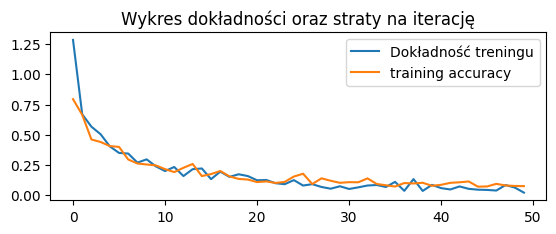

In [28]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig1.plot(total_loss_train[0:-1:8], label = 'Dokładność treningu')
fig1.plot(total_loss_val, label = 'training accuracy')
plt.title("Wykres dokładności oraz straty na iterację")
plt.legend()
plt.show()


In [36]:
len(total_loss_val)

50

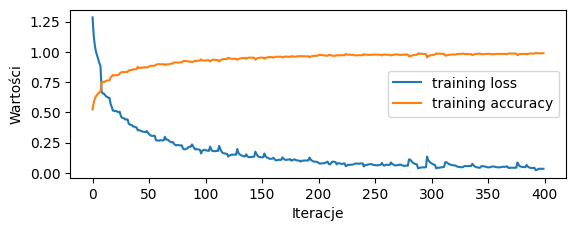

In [29]:
fig = plt.figure(num=2)
fig1 = fig.add_subplot(2, 1, 1)
fig1.plot(total_loss_train, label='training loss')
fig1.plot(total_acc_train, label='training accuracy')

plt.legend()
plt.xlabel('Iteracje')  # Add x-axis label
plt.ylabel('Wartości')  # Add y-axis label

plt.show()

In [34]:
len(total_acc_train[0:-1:8])

50

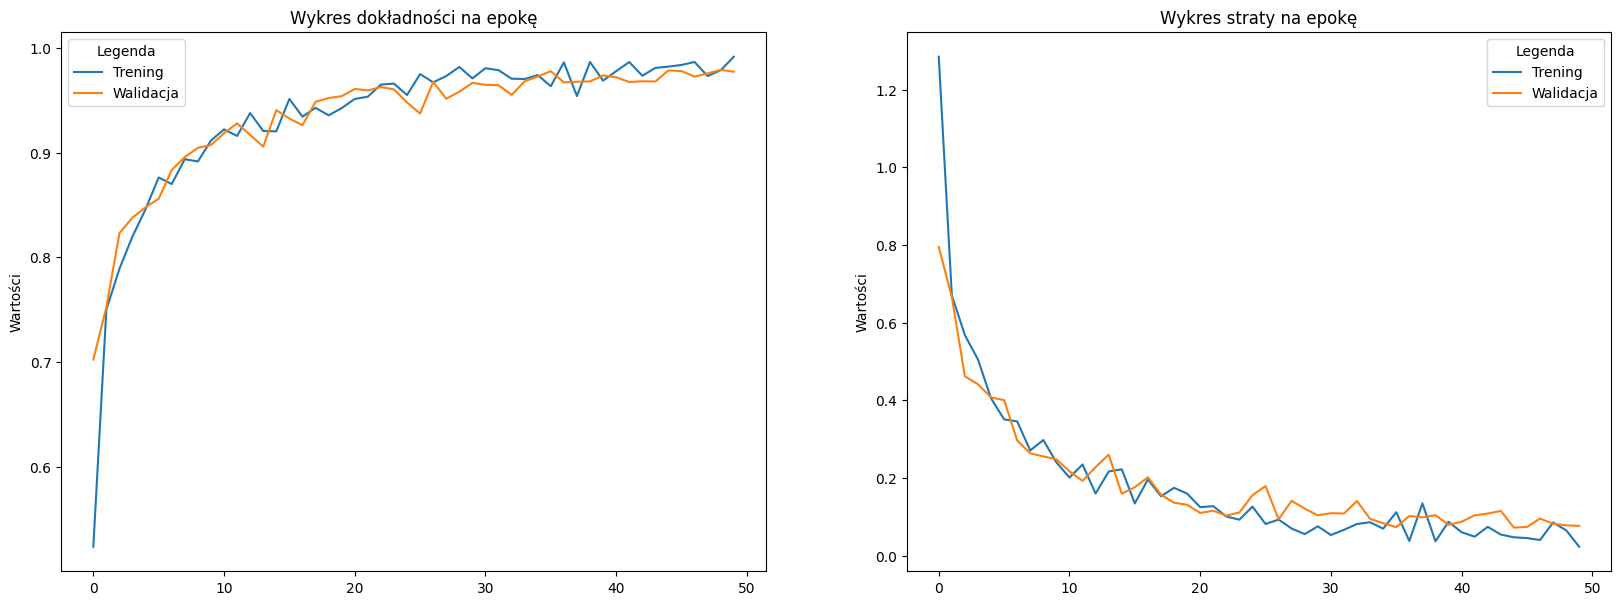

In [38]:
# Assuming you already have these lists
epochs = list(range(50))  # Replace with your actual epoch values
train_acc_values = total_acc_train[0:-1:8]  # Replace with your actual train accuracy values
val_acc_values = total_acc_val  # Replace with your actual validation accuracy values
train_loss_values = total_loss_train[0:-1:8]  # Replace with your actual train loss values
val_loss_values = total_loss_val  # Replace with your actual validation loss values
# Plot the data using Matplotlib
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Plot accuracy
axes[0].plot(epochs, train_acc_values, label='Trening')
axes[0].plot(epochs, val_acc_values, label='Walidacja')
axes[0].set_title('Wykres dokładności na epokę')
axes[0].set_ylabel('Wartości')
axes[0].legend(title='Legenda')

# Plot loss
axes[1].plot(epochs, train_loss_values, label='Trening')
axes[1].plot(epochs, val_loss_values, label='Walidacja')
axes[1].set_title('Wykres straty na epokę')
axes[1].set_ylabel('Wartości')
axes[1].legend(title='Legenda')

plt.show()

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

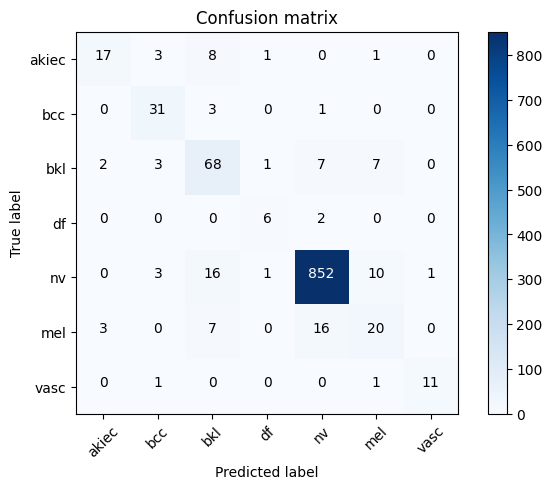

In [74]:
model.eval()
y_prob = []
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        y_prob.append(outputs)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix

plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel','vasc']
plot_confusion_matrix(confusion_mtx, plot_labels)
y_prob = [a.squeeze().tolist() for a in y_prob]


In [79]:
y_prob = [inner_list for outer_list in y_prob for inner_list in outer_list]

print(y_prob)

[[-24.06337547302246, -22.011632919311523, -1.2768231630325317, -11.405783653259277, 7.500336170196533, -9.029796600341797, -10.385048866271973], [-23.957191467285156, 5.316051006317139, -16.577486038208008, -19.56818962097168, 6.345856189727783, -13.09884262084961, -23.387636184692383], [-17.69352149963379, -21.56316375732422, -8.636863708496094, -15.881308555603027, 3.61384654045105, -0.09313666820526123, -17.483667373657227], [16.832067489624023, -17.924657821655273, -8.9435453414917, -15.691011428833008, -9.012550354003906, -13.942399978637695, -31.42104148864746], [-9.874115943908691, -20.72593879699707, -6.7602620124816895, -15.426976203918457, 4.67319393157959, -1.716435194015503, -19.57234001159668], [-17.974206924438477, -14.600037574768066, 5.355181694030762, -7.011825084686279, -2.8547728061676025, -8.852590560913086, -26.249958038330078], [-41.186073303222656, -35.58393859863281, -13.33043098449707, -22.42570686340332, 14.887733459472656, -21.508317947387695, -13.5878086090

In [81]:
len(y_prob)

1103

In [99]:
from sklearn.preprocessing import MinMaxScaler
my_array = np.array(y_prob, dtype=float)
# Find the minimum value in each array
min_values = np.min(my_array, axis=1, keepdims=True)

# Add the absolute value of the minimum value to make them non-negative
my_array = my_array + np.abs(min_values)

# Scale each array to sum up to 1
my_array = my_array / my_array.sum(axis=1, keepdims=True)


0.9999999999999999

In [69]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)


              precision    recall  f1-score   support

       akiec       0.77      0.57      0.65        30
         bcc       0.76      0.89      0.82        35
         bkl       0.67      0.77      0.72        88
          df       0.67      0.75      0.71         8
          nv       0.97      0.96      0.97       883
         mel       0.51      0.43      0.47        46
        vasc       0.92      0.85      0.88        13

    accuracy                           0.91      1103
   macro avg       0.75      0.75      0.74      1103
weighted avg       0.91      0.91      0.91      1103



In [70]:
report = classification_report(y_label, y_predict, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.astype({'support':'int'})
report_df = report_df.rename(columns={'precision': 'precyzja', 'recall': 'czułość', 'f1-score': 'miara F1', 'support': 'poparcie'})
report_df = report_df.drop('accuracy')
report_df = report_df.drop('macro avg')
report_df = report_df.drop('weighted avg')

In [71]:
display(report_df)

,precyzja,czułość,miara F1,poparcie
0,0.772727,0.566667,0.653846,30
1,0.756098,0.885714,0.815789,35
2,0.666667,0.772727,0.715789,88
3,0.666667,0.750000,0.705882,8
4,0.970387,0.964892,0.967632,883
5,0.512821,0.434783,0.470588,46
6,0.916667,0.846154,0.880000,13


Text(0, 0.5, 'Fraction classified incorrectly')

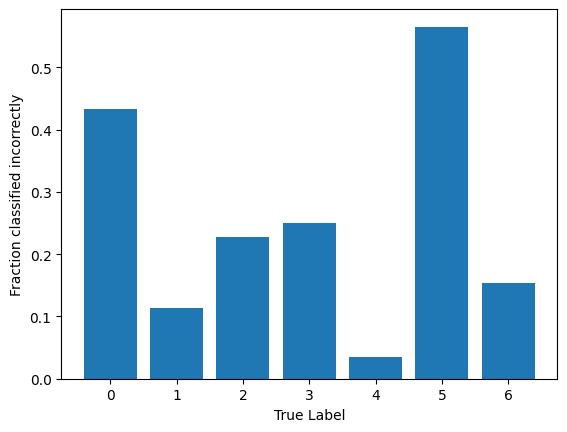

In [43]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')


In [44]:
# save model
torch.save(model.state_dict(), "model_class.pth")


In [ ]:
# Model class must be defined somewhere
## model = torch.load(PATH)
## model.eval()


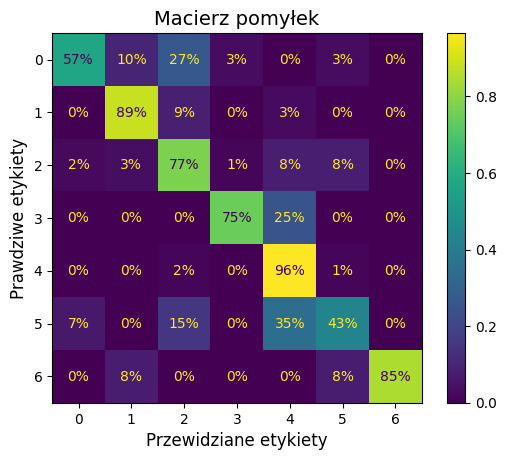

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_label, y_predict, normalize='true', values_format=".0%")
# Customize axis labels
plt.xlabel('Przewidziane etykiety', fontsize=12)
plt.ylabel('Prawdziwe etykiety', fontsize=12)
plt.title('Macierz pomyłek', fontsize=14)

# Show the plot
plt.show()

In [73]:
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_label, classes=np.arange(7))

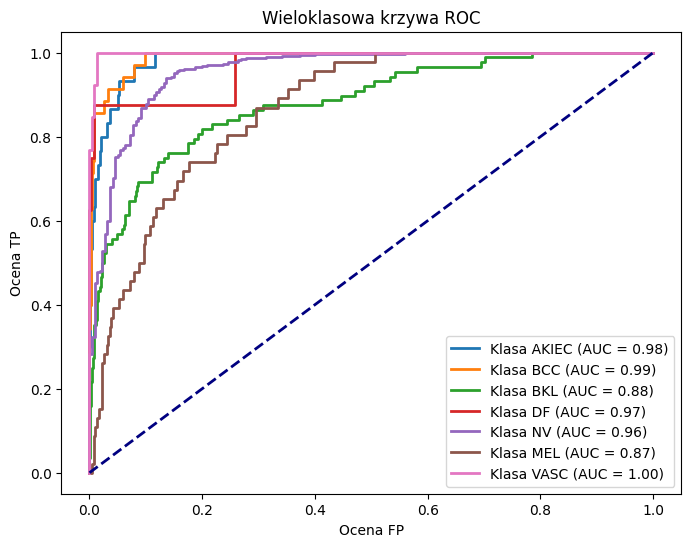

In [103]:
from sklearn.metrics import roc_curve, auc
lesion_classes = ['AKIEC', 'BCC', 'BKL', 'DF', 'NV', 'MEL', 'VASC']
# Compute ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(7):
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], my_array[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Klasa {lesion_classes[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Ocena FP')
plt.ylabel('Ocena TP')
plt.title('Wieloklasowa krzywa ROC')
plt.legend(loc='lower right')
plt.show()